# Creating the f1rate dataset in another format

In [1]:
import numpy as np
import uproot as ur
import matplotlib.pyplot as plt
import numba as nb
import pandas as pd
import copy
import sys

from scipy import stats
from numba import njit

In [2]:
sys.path.append('../')

from src import load_data

## Loading root file and preprocessing the data

- We load the root file using uproot and show its contents. We can then obtain a dictionary where keys are some of the TTree names and values are numpy arrays containing the data. **Note that we might only keep a subset of the information**.

In [3]:
data_dict = load_data.load_data_as_dict(root_filename = "../data/f1rate.root",
                                        TTree_features_dict={
                        "f1rate":
                                ["time_since_saa", # saa 
                               "raz",
                               "decz",
                               "rax",
                               "decx",
                               # "obox_mode",
                               "temperature",  # fe_temp sum ?
                               "glon", 
                               "glat",
                               "unix_time",  # tunix
                               "fe_cosmic",  # sum ?
                               "rate",  # fe_rate why 12 instead of 25 ?
                               "corrected",  # new, what does it mean ? 12 dim why ?
                               "correrr",  # new, what does it mean ? 12 dim why ?
                               "config",  # new, what does it mean ? interested in config=42, meaning ?
                               "is_orbit_up", # new, what does it mean ?
                               "crabarf"  # new, what does it mean ?
                                # need magnetic field info too.
                                ]})

TTree: f1rate's contents:
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
unix_time            | double                   | AsDtype('>f8')
rate                 | double[12]               | AsDtype("('>f8', (12,))")
glat                 | double                   | AsDtype('>f8')
glon                 | double                   | AsDtype('>f8')
temperature          | float                    | AsDtype('>f4')
fe_cosmic            | float                    | AsDtype('>f4')
corrected            | double[12]               | AsDtype("('>f8', (12,))")
correrr              | double[12]               | AsDtype("('>f8', (12,))")
config               | int32_t                  | AsDtype('>i4')
raz                  | double                   | AsDtype('>f8')
decz                 | double                   | AsDtype('>f8')
rax                  | double                   | AsDtype('>f8')

<!--The TTree `B_field` contains information on the magnetic field and is aligned with the data in `t_hk_obox`--->

In [4]:
data_dict.keys()

dict_keys(['time_since_saa', 'raz', 'decz', 'rax', 'decx', 'temperature', 'glon', 'glat', 'unix_time', 'fe_cosmic', 'rate', 'corrected', 'correrr', 'config', 'is_orbit_up', 'crabarf'])

- Create a pandas dataframe containing all the features we selected where `fe_temp`, `fe_cosmic` and `fe_rate` are summed up over the modules (sum of $25$ modules).

In [5]:
def try_sum_axis_1(k, v):
    try:
        return "sum_"+k, np.sum(v, axis=1)
    except:
        return k, v


In [6]:
data_df = pd.DataFrame.from_dict(dict(try_sum_axis_1(k, v) for k, v in data_dict.items()))
data_df

,time_since_saa,raz,decz,rax,decx,temperature,glon,glat,unix_time,fe_cosmic,sum_rate,sum_corrected,sum_correrr,config,is_orbit_up,crabarf
0,591657.6445,176.364735,32.723959,55.658503,38.473001,7.000000,18.994245,24.327195,1.474542e+09,981.0,2053.521003,-4964.203317,3229.323227,0,True,2.920479
1,591657.6445,176.364735,32.723959,55.658503,38.473001,7.000000,18.994245,24.327195,1.474542e+09,981.0,2471.362994,-4546.361325,3239.308213,0,True,2.920479
2,591659.6445,176.482314,32.807127,55.682265,38.460789,7.000000,19.101418,24.404622,1.474542e+09,916.0,2119.751003,-5087.921151,182.876108,0,True,2.920479
3,591659.6445,176.482314,32.807127,55.682265,38.460789,7.000000,19.101418,24.404622,1.474542e+09,916.0,2010.896004,-5196.776150,179.898002,0,True,2.920479
4,591661.6450,176.599775,32.890062,55.706705,38.448009,7.000000,19.208824,24.481955,1.474542e+09,1217.0,2154.339000,-5053.333154,183.278855,0,True,2.920479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9961087,510.0235,82.628975,-22.327772,279.804031,-66.738812,32.599998,-12.969739,-11.397568,1.490983e+09,2668.0,0.000000,-7869.301057,124.127219,47,True,3.282349
9961088,510.0235,82.628975,-22.327772,279.804031,-66.738812,32.599998,-12.969739,-11.397568,1.490983e+09,2668.0,0.000000,-7869.301057,124.127219,47,True,3.282349
9961089,512.0235,82.741492,-22.242510,279.817775,-66.837853,32.599998,-12.878656,-11.311159,1.490983e+09,2970.0,0.000000,-7869.301057,124.127219,47,True,3.282349
9961090,512.0235,82.741492,-22.242510,279.817775,-66.837853,32.599998,-12.878656,-11.311159,1.490983e+09,2970.0,0.000000,-7869.301057,124.127219,47,True,3.282349


In [7]:
data_df.dtypes

time_since_saa    float64
raz               float64
decz              float64
rax               float64
decx              float64
temperature       float32
glon              float64
glat              float64
unix_time         float64
fe_cosmic         float32
sum_rate          float64
sum_corrected     float64
sum_correrr       float64
config              int32
is_orbit_up          bool
crabarf           float64
dtype: object

In [8]:
tunix_name, sum_fe_rate_name = 'unix_time', 'sum_rate'

**Need for normalizing some features ? Probably, we'll do it later and after splitting the data (otherwise data leakage)!!**

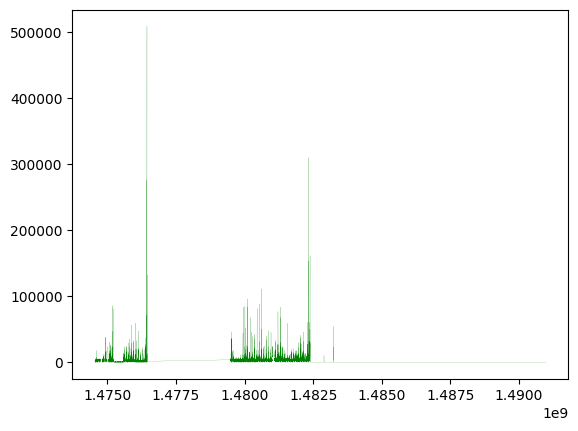

In [9]:
plt.plot(data_df[tunix_name], data_df[sum_fe_rate_name], 'g', linewidth=0.1)
plt.show()

In [10]:
data_df[tunix_name][:10]-data_df[tunix_name][:10].min()

0    0.000000
1    1.000060
2    2.000585
3    3.001892
4    4.005416
5    5.010427
6    6.010627
7    7.011624
8    8.012198
9    9.012450
Name: unix_time, dtype: float64

- Filter out the data and bin the data

We first remove a huge part of missing data

In [11]:
last_non_zero = data_df.shape[0]-(np.flip(data_df[sum_fe_rate_name])>0).argmax() - 1

In [12]:
data_df = data_df.iloc[:last_non_zero+1, :]
data_df

,time_since_saa,raz,decz,rax,decx,temperature,glon,glat,unix_time,fe_cosmic,sum_rate,sum_corrected,sum_correrr,config,is_orbit_up,crabarf
0,591657.6445,176.364735,32.723959,55.658503,38.473001,7.000000,18.994245,24.327195,1.474542e+09,981.0,2053.521003,-4964.203317,3229.323227,0,True,2.920479
1,591657.6445,176.364735,32.723959,55.658503,38.473001,7.000000,18.994245,24.327195,1.474542e+09,981.0,2471.362994,-4546.361325,3239.308213,0,True,2.920479
2,591659.6445,176.482314,32.807127,55.682265,38.460789,7.000000,19.101418,24.404622,1.474542e+09,916.0,2119.751003,-5087.921151,182.876108,0,True,2.920479
3,591659.6445,176.482314,32.807127,55.682265,38.460789,7.000000,19.101418,24.404622,1.474542e+09,916.0,2010.896004,-5196.776150,179.898002,0,True,2.920479
4,591661.6450,176.599775,32.890062,55.706705,38.448009,7.000000,19.208824,24.481955,1.474542e+09,1217.0,2154.339000,-5053.333154,183.278855,0,True,2.920479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4361477,48024.8355,127.957927,-14.211604,199.954172,50.669385,29.200001,-6.731155,-22.868921,1.483235e+09,7299.0,3511.376999,-2763.356122,175.399622,21,False,3.256934
4361478,48024.8355,127.957927,-14.211604,199.954172,50.669385,29.200001,-6.731155,-22.868921,1.483235e+09,7299.0,3499.366995,-2775.366126,174.104896,21,False,3.256934
4361479,48026.8355,128.065959,-14.284759,199.943709,50.697163,29.200001,-6.626753,-22.947710,1.483235e+09,6834.0,3517.753991,-2756.979129,176.713991,21,False,3.256934
4361480,48026.8355,128.065959,-14.284759,199.943709,50.697163,29.200001,-6.626753,-22.947710,1.483235e+09,6834.0,3700.420995,-2574.312125,181.155275,21,False,3.256934


Then we "bin" the data (like profile hist but without error bars and without plotting)

In [13]:
tunix_min = data_df[tunix_name].min()
tunix_shifted = data_df[tunix_name] - tunix_min
bins = np.arange(0, tunix_shifted.max()+2, 2)

# Obtain indices of the bins in which the data falls.
# It will take the bin on the right, not the one of the left
indices_digitized = np.digitize(tunix_shifted, bins)

# Quantized Shifted Time
t = bins[indices_digitized]

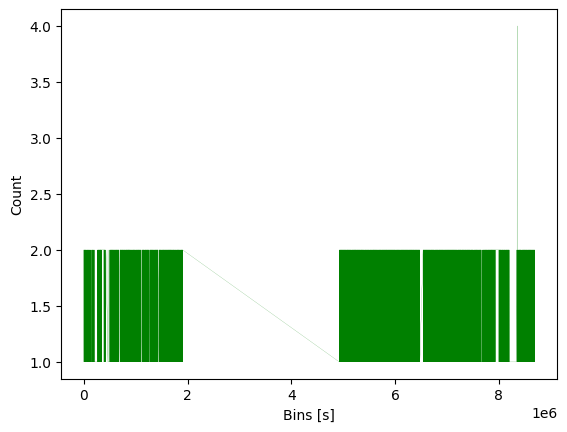

In [14]:
uniques_idx, counts_idx = np.unique(indices_digitized, return_counts=True)
plt.plot(bins[uniques_idx], counts_idx, 'g', linewidth=0.1)
plt.xlabel("Bins [s]")
plt.ylabel("Count")  # nb. data falling into bin
plt.show()

In [15]:
np.unique(bins[uniques_idx]).size, bins.size

(2187136, 4346750)

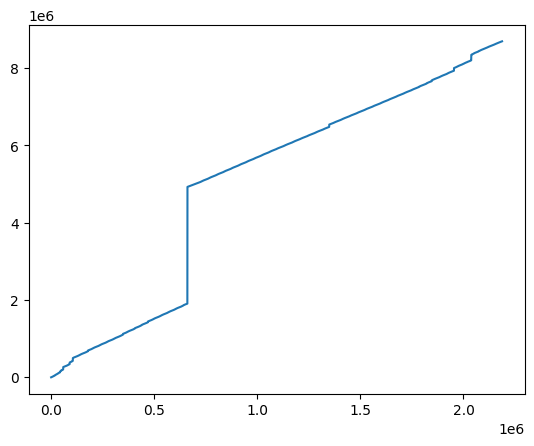

In [16]:
plt.plot(np.unique(bins[uniques_idx]))

Note: There are **empty bins**, need to be careful with them !!

In [17]:
data_df.loc[:, ("idx")] = indices_digitized

/tmp/ipykernel_12045/3418129158.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df.loc[:, ("idx")] = indices_digitized


In [18]:
data_df

,time_since_saa,raz,decz,rax,decx,temperature,glon,glat,unix_time,fe_cosmic,sum_rate,sum_corrected,sum_correrr,config,is_orbit_up,crabarf,idx
0,591657.6445,176.364735,32.723959,55.658503,38.473001,7.000000,18.994245,24.327195,1.474542e+09,981.0,2053.521003,-4964.203317,3229.323227,0,True,2.920479,1
1,591657.6445,176.364735,32.723959,55.658503,38.473001,7.000000,18.994245,24.327195,1.474542e+09,981.0,2471.362994,-4546.361325,3239.308213,0,True,2.920479,1
2,591659.6445,176.482314,32.807127,55.682265,38.460789,7.000000,19.101418,24.404622,1.474542e+09,916.0,2119.751003,-5087.921151,182.876108,0,True,2.920479,2
3,591659.6445,176.482314,32.807127,55.682265,38.460789,7.000000,19.101418,24.404622,1.474542e+09,916.0,2010.896004,-5196.776150,179.898002,0,True,2.920479,2
4,591661.6450,176.599775,32.890062,55.706705,38.448009,7.000000,19.208824,24.481955,1.474542e+09,1217.0,2154.339000,-5053.333154,183.278855,0,True,2.920479,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4361477,48024.8355,127.957927,-14.211604,199.954172,50.669385,29.200001,-6.731155,-22.868921,1.483235e+09,7299.0,3511.376999,-2763.356122,175.399622,21,False,3.256934,4346747
4361478,48024.8355,127.957927,-14.211604,199.954172,50.669385,29.200001,-6.731155,-22.868921,1.483235e+09,7299.0,3499.366995,-2775.366126,174.104896,21,False,3.256934,4346748
4361479,48026.8355,128.065959,-14.284759,199.943709,50.697163,29.200001,-6.626753,-22.947710,1.483235e+09,6834.0,3517.753991,-2756.979129,176.713991,21,False,3.256934,4346748
4361480,48026.8355,128.065959,-14.284759,199.943709,50.697163,29.200001,-6.626753,-22.947710,1.483235e+09,6834.0,3700.420995,-2574.312125,181.155275,21,False,3.256934,4346749


In [19]:
data_df = data_df.groupby("idx").mean()

In [20]:
data_df

,time_since_saa,raz,decz,rax,decx,temperature,glon,glat,unix_time,fe_cosmic,sum_rate,sum_corrected,sum_correrr,config,is_orbit_up,crabarf
idx,,,,,,,,,,,,,,,,
1,591657.64450,176.364735,32.723959,55.658503,38.473001,7.000000,18.994245,24.327195,1.474542e+09,981.0,2262.441999,-4755.282321,3234.315720,0.0,1.0,2.920479
2,591659.64450,176.482314,32.807127,55.682265,38.460789,7.000000,19.101418,24.404622,1.474542e+09,916.0,2065.323503,-5142.348650,181.387055,0.0,1.0,2.920479
3,591661.64500,176.599775,32.890062,55.706705,38.448009,7.000000,19.208824,24.481955,1.474542e+09,1217.0,2137.201500,-5070.470654,182.848995,0.0,1.0,2.920479
4,591663.64550,176.719218,32.972342,55.730402,38.437974,7.000000,19.316307,24.559214,1.474542e+09,1133.0,2347.365499,-4860.306655,188.240112,0.0,1.0,2.920479
5,591665.64550,176.838005,33.054827,55.755163,38.426151,7.000000,19.423977,24.636383,1.474542e+09,1254.0,2241.938002,-4965.734152,185.716812,0.0,1.0,2.920479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4346745,48019.83550,127.687393,-14.028727,199.977940,50.600388,29.200001,-6.991608,-22.671536,1.483235e+09,6425.0,3582.809497,-154.557063,2719.685307,21.0,0.0,3.256934
4346746,48021.83550,127.795336,-14.101992,199.968174,50.628115,29.200001,-6.887520,-22.750537,1.483235e+09,6673.5,3587.301997,-2687.431123,179.234382,21.0,0.0,3.256934
4346747,48023.83550,127.903716,-14.175101,199.958843,50.655619,29.200001,-6.783300,-22.829467,1.483235e+09,7162.5,3541.564499,-2733.168622,176.986428,21.0,0.0,3.256934


In [21]:
data_df.dtypes  # everything changed to float64 due to .mean()

time_since_saa    float64
raz               float64
decz              float64
rax               float64
decx              float64
temperature       float32
glon              float64
glat              float64
unix_time         float64
fe_cosmic         float32
sum_rate          float64
sum_corrected     float64
sum_correrr       float64
config            float64
is_orbit_up       float64
crabarf           float64
dtype: object

In [22]:
data_df.describe()

,time_since_saa,raz,decz,rax,decx,temperature,glon,glat,unix_time,fe_cosmic,sum_rate,sum_corrected,sum_correrr,config,is_orbit_up,crabarf
count,2.187136e+06,2.187136e+06,2.187136e+06,2.187136e+06,2.187136e+06,2.187136e+06,2.187136e+06,2.187136e+06,2.187136e+06,2.187136e+06,2.187136e+06,2.187136e+06,2.187136e+06,2.187136e+06,2.187136e+06,2.187136e+06
mean,6.811279e+04,1.825782e+02,9.377195e+00,2.389452e+02,2.681589e+01,3.231701e+01,5.401029e+00,3.828956e+00,1.479542e+09,6.229764e+03,2.919354e+03,-3.347291e+03,5.239100e+02,1.172828e+01,5.002606e-01,1.593025e+00
std,3.267036e+05,1.012368e+02,3.013758e+01,9.542267e+01,3.797718e+01,3.473311e+00,1.095006e+02,2.909341e+01,2.767185e+06,4.990897e+03,3.286878e+03,3.579276e+03,9.565082e+02,7.670296e+00,4.999097e-01,1.566204e+00
min,0.000000e+00,3.679630e-04,-5.203507e+01,6.037243e-04,-8.995152e+01,7.000000e+00,-1.799997e+02,-4.276608e+01,1.474542e+09,0.000000e+00,0.000000e+00,-2.514312e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.167450e+04,9.644907e+01,-1.840433e+01,1.818358e+02,2.512008e+01,2.960000e+01,-1.010178e+02,-2.369305e+01,1.476173e+09,3.163000e+03,2.085788e+03,-4.355488e+03,1.522408e+02,4.000000e+00,0.000000e+00,0.000000e+00
50%,2.279829e+04,1.847613e+02,1.181221e+01,2.772427e+02,3.897176e+01,3.300000e+01,2.298485e+01,7.330655e+00,1.480451e+09,4.318500e+03,2.819120e+03,-3.469288e+03,1.842797e+02,1.100000e+01,1.000000e+00,2.009572e+00
75%,4.252161e+04,2.693600e+02,3.727228e+01,3.121649e+02,5.005919e+01,3.500000e+01,1.015212e+02,3.164451e+01,1.481731e+09,7.423000e+03,3.478000e+03,-2.559127e+03,2.534599e+02,1.900000e+01,1.000000e+00,3.272600e+00
max,3.113011e+06,3.599997e+02,5.380582e+01,3.599993e+02,8.994561e+01,3.830000e+01,1.799997e+02,4.276590e+01,1.483235e+09,1.056040e+05,4.511287e+05,4.410865e+05,9.900932e+03,2.800000e+01,1.000000e+00,3.526056e+00


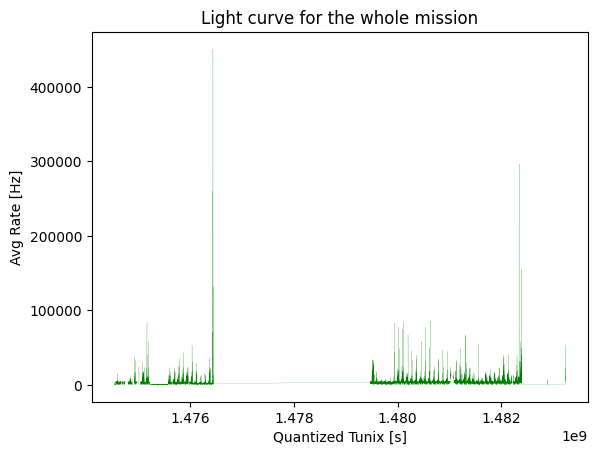

In [23]:
plt.plot(data_df[tunix_name], data_df[sum_fe_rate_name], 'g', linewidth=0.1)
plt.xlabel("Quantized Tunix [s]")
plt.ylabel("Avg Rate [Hz]")  # Nb. photons per second (averaged over each bin)
plt.title("Light curve for the whole mission")
plt.show()

Note: We need to be careful about the empty bins, so it's not really equidistant times between each example. We won't be able to use FFT

In [24]:
# Uncomment below if want to export the data into a CSV file
# import os  

# os.makedirs('../data', exist_ok=True)
# data_df.to_csv('../data/f1rate_dataset_binned.csv', index=False)  

If we filter out data contiguously from either the beginning of the light curve or from the end, it's fine. Otherwise, we wouldn't be able to apply FFT. This would require something else.

Therefore, it's easier for us to, for the moment, remove what happens before and during the moment astronauts went onboard the space station (before and during the huge middle part with missing data).


660703 3830.64199924469


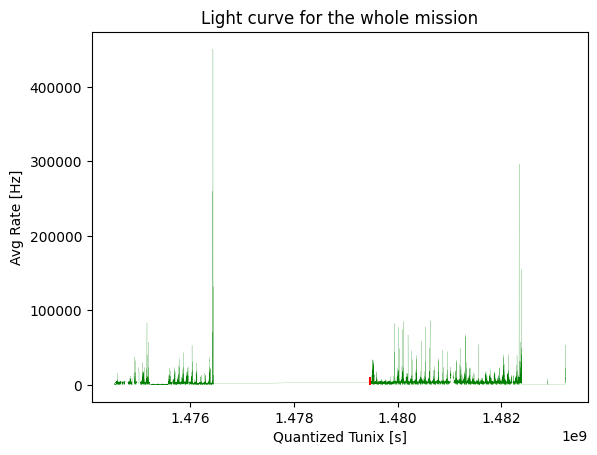

In [25]:
# Find idx
idx_right = np.argmax((data_df[tunix_name] > 1.4775*1e9) & (data_df[sum_fe_rate_name] > 0))
print(idx_right, data_df[sum_fe_rate_name].iloc[idx_right])

# Let's visualize to see if correct idx
plt.plot(data_df[tunix_name], data_df[sum_fe_rate_name], 'g', linewidth=0.1)
plt.vlines(data_df[tunix_name].iloc[idx_right], 0, 10_000, 'r')
plt.xlabel("Quantized Tunix [s]")
plt.ylabel("Avg Rate [Hz]")  # Nb. photons per second (averaged over each bin)
plt.title("Light curve for the whole mission")
plt.show()

In [26]:
data_df = data_df.iloc[idx_right:data_df.shape[0], :]

In [27]:
import os  

os.makedirs('../data', exist_ok=True)
data_df.to_csv('../data/f1rate_dataset.csv', index=False)  

In [28]:
corr = data_df.corr()

In [29]:
corr

,time_since_saa,raz,decz,rax,decx,temperature,glon,glat,unix_time,fe_cosmic,sum_rate,sum_corrected,sum_correrr,config,is_orbit_up,crabarf
time_since_saa,1.000000,0.002901,-0.037584,-0.044218,-0.105227,-0.192044,-0.008609,-0.013483,-0.203571,0.028000,0.001779,0.014547,0.029335,-0.093561,0.004710,-0.002196
raz,0.002901,1.000000,-0.185267,-0.160202,-0.214530,-0.065112,0.004876,-0.138167,-0.037312,-0.033519,-0.082488,-0.077973,-0.015856,-0.068204,-0.218756,-0.788633
decz,-0.037584,-0.185267,1.000000,0.355419,0.069470,-0.005491,-0.043918,0.975289,0.094495,-0.207340,-0.008404,0.026433,-0.090838,0.121392,0.074655,0.312463
rax,-0.044218,-0.160202,0.355419,1.000000,0.436966,0.058801,-0.016872,0.265256,0.064572,0.051618,0.118964,0.093989,-0.000719,0.128617,0.189649,0.109504
decx,-0.105227,-0.214530,0.069470,0.436966,1.000000,0.262327,0.007813,-0.141269,0.501280,0.074345,-0.037594,-0.051796,0.020497,0.507530,0.374849,0.233600
temperature,-0.192044,-0.065112,-0.005491,0.058801,0.262327,1.000000,-0.006035,-0.067837,0.636908,0.050774,0.045016,0.016205,-0.027613,0.568077,0.115303,0.097545
glon,-0.008609,0.004876,-0.043918,-0.016872,0.007813,-0.006035,1.000000,-0.046448,0.004566,0.060282,-0.023989,0.007643,-0.004124,0.001289,-0.009598,-0.011302
glat,-0.013483,-0.138167,0.975289,0.265256,-0.141269,-0.067837,-0.046448,1.000000,-0.018972,-0.235799,-0.005672,0.032958,-0.098339,0.006702,-0.003077,0.256941
unix_time,-0.203571,-0.037312,0.094495,0.064572,0.501280,0.636908,0.004566,-0.018972,1.000000,0.023986,-0.237317,-0.204219,-0.008946,0.849730,-0.002348,0.027871
fe_cosmic,0.028000,-0.033519,-0.207340,0.051618,0.074345,0.050774,0.060282,-0.235799,0.023986,1.000000,0.308562,0.243763,0.278671,-0.008671,-0.015151,-0.022416


Text(0.5, 1.0, 'Correlation Matrix between types of measurements')

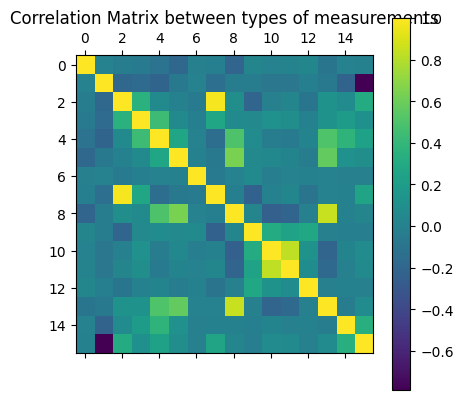

In [30]:
plt.matshow(corr)
plt.colorbar()

plt.title('Correlation Matrix between types of measurements')

In [31]:
corr["sum_rate"]

time_since_saa    0.001779
raz              -0.082488
decz             -0.008404
rax               0.118964
decx             -0.037594
temperature       0.045016
glon             -0.023989
glat             -0.005672
unix_time        -0.237317
fe_cosmic         0.308562
sum_rate          1.000000
sum_corrected     0.826864
sum_correrr       0.129282
config           -0.205383
is_orbit_up       0.019052
crabarf           0.071049
Name: sum_rate, dtype: float64

In [32]:
corr["sum_corrected"]

time_since_saa    0.014547
raz              -0.077973
decz              0.026433
rax               0.093989
decx             -0.051796
temperature       0.016205
glon              0.007643
glat              0.032958
unix_time        -0.204219
fe_cosmic         0.243763
sum_rate          0.826864
sum_corrected     1.000000
sum_correrr       0.079329
config           -0.178846
is_orbit_up      -0.009281
crabarf           0.069405
Name: sum_corrected, dtype: float64

`Config`  **TODO: filter based on config, BEFORE groupby/binning. Need to check for equidistant time too**

In [33]:
unique_configs, counts_configs = np.unique(data_df["config"], return_counts=True)
pd.DataFrame([unique_configs, counts_configs])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,3.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0,22.0,23.0,24.0,26.0,27.0,28.0
1,308637.0,63674.0,37048.0,37721.0,37001.0,37022.0,163115.0,5849.0,124673.0,145921.0,3975.0,32563.0,61283.0,332186.0,22196.0,1346.0,2572.0,110.0,108195.0,1346.0


In [34]:
unique_configs, counts_configs = np.unique(data_dict["config"], return_counts=True)
pd.DataFrame([unique_configs, counts_configs])

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,0,2,3,4,5,6,7,9,10,11,...,32,33,37,40,41,42,43,45,46,47
1,17966,161808,794107,281127,118261,194013,366826,127138,73987,75335,...,74011,72548,1080353,34310,14665,3956646,185468,132714,32045,8364
